# Installations

## Import and load packages

Install the packages that we need in order to run on Google Colab. Always check the version number because it is more recent than what was used in the book. Version mismatch may or may not be a problem.

In [1]:
import sklearn

print(sklearn.__version__)

1.6.1


Google Colab does not have PennyLane by default, so install it first. This should be very fast (seconds).

In [2]:
import pennylane as qml

print(qml.__version__)

0.41.1


Import numpy and set a seed for reproducibility.

In [3]:
import numpy as np

seed = 1234
np.random.seed(seed)

In [4]:
import matplotlib.pyplot as plt

## Import and visualize the dataset

In [6]:
from utils import simple_train_test_split
import os

# Define the noise level in ppm
noise_ppm = 0

# Import the exoplanet data:

path = f'data/processed_spectra/{noise_ppm}ppm'

data_normal = np.load(os.path.join(path, f'normal_{noise_ppm}ppm.npy'))
data_anom = np.load(os.path.join(path, f'anom_{noise_ppm}ppm.npy'))
wavelengths = np.load(os.path.join('data', 'wavelengths.npy'))

# # Convert to tensors
# data_normal = torch.tensor(data_normal, dtype=torch.float32)
# data_anom = torch.tensor(data_anom, dtype=torch.float32)

# Split data into training and testing
data_normal_train, data_normal_test = simple_train_test_split(data_normal)

In [7]:
## Load latent data

latent_data_path = f'regularized_autoencoder/{noise_ppm}ppm'

latent_normal_test = np.load(os.path.join(latent_data_path, f'latent_normal_test_{noise_ppm}ppm.npy'))
latent_normal_train = np.load(os.path.join(latent_data_path, f'latent_normal_train_{noise_ppm}ppm.npy'))
latent_anom = np.load(os.path.join(latent_data_path, f'latent_anom_{noise_ppm}ppm.npy'))

# Print all the shapes
print(f"data_normal_train shape: {data_normal_train.shape}")
print(f"data_normal_test  shape: {data_normal_test.shape}")
print(f"data_anom         shape: {data_anom.shape}")

# Print the shapes of the latent data
print(f"latent_normal_train shape: {latent_normal_train.shape}")
print(f"latent_normal_test  shape: {latent_normal_test.shape}")
print(f"latent_anom         shape: {latent_anom.shape}")

data_normal_train shape: (12303, 52)
data_normal_test  shape: (3076, 52)
data_anom         shape: (17869, 52)
latent_normal_train shape: (12303, 8)
latent_normal_test  shape: (3076, 8)
latent_anom         shape: (17869, 8)


Just the two classes we are considering:

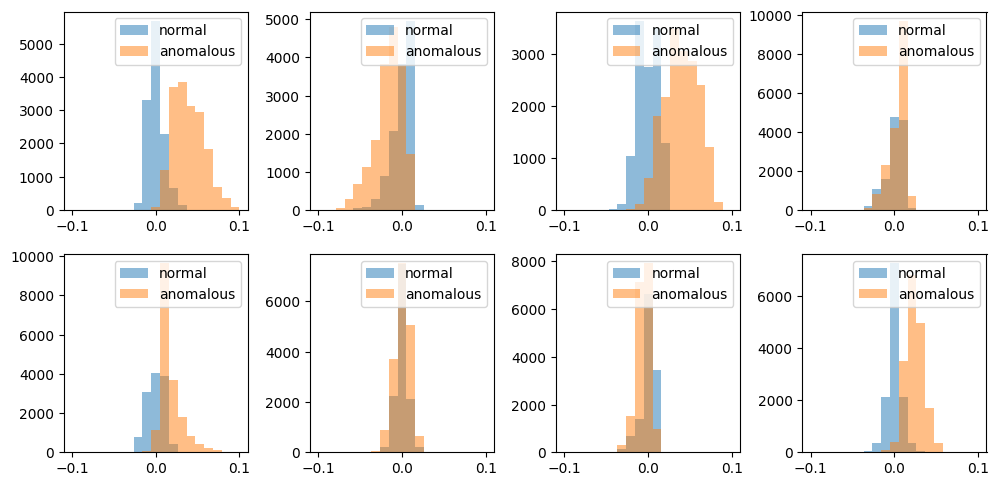

In [13]:
fig = plt.subplots(2,4,figsize=(10,5))
plt.tight_layout()

bins = np.linspace(-0.1, 0.1, 20)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(latent_normal_train[:,i], bins=bins, alpha=0.5, label='normal')
    plt.hist(latent_anom[:,i], bins=bins, alpha=0.5, label='anomalous')
    plt.legend()

## Preprocess the data

~~Create a train-test split 90:10.~~

In [14]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

Feature maps expect the features to be normalized. Here we use the MaxAbsScaler but other options are also possible. Note that the scaler is fitted to the training data only to avoid contamination from the testing data.

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
x_train_scaled = scaler.fit_transform(latent_normal_train)
x_test_scaled = scaler.transform(latent_normal_test)
x_anom_scaled = scaler.transform(latent_anom)

Check the features after rescaling:

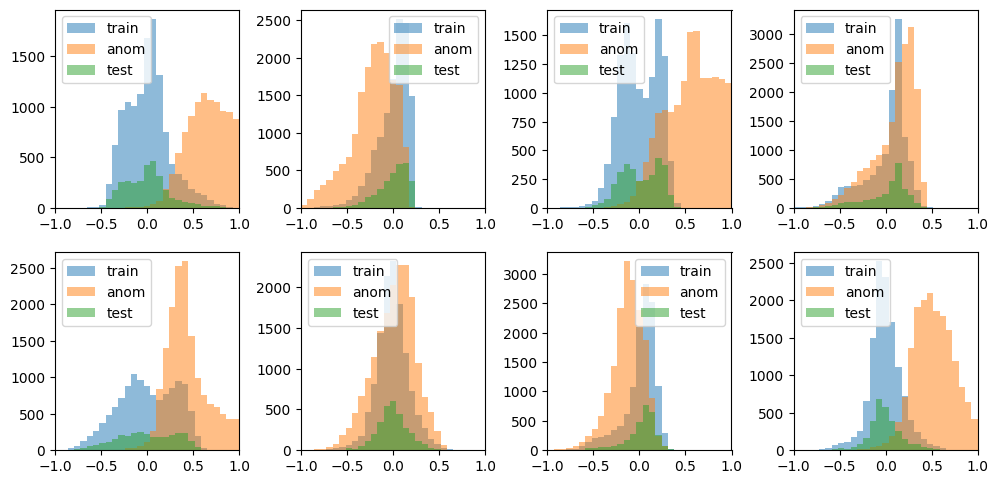

In [21]:
fig = plt.subplots(2,4,figsize=(10,5))
plt.tight_layout()

bins = np.linspace(-1, 1, 30)

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.hist(x_train_scaled[:,i], bins=bins, alpha=0.5, label='train')
    plt.hist(x_anom_scaled[:,i], bins=bins, alpha=0.5, label='anom')
    plt.hist(x_test_scaled[:,i], bins=bins, alpha=0.5, label='test')
    plt.xlim(-1, 1)
    plt.legend()

Now also transform the testing data with the already trained scaler.

In [22]:
print('Train')
for i in range(8):
    print(i, np.min(x_train_scaled[:,i]), np.max(x_train_scaled[:,i]))

print('Test')
for i in range(8):
    print(i, np.min(x_test_scaled[:,i]), np.max(x_test_scaled[:,i]))

print('Anom')
for i in range(8):
    print(i, np.min(x_anom_scaled[:,i]), np.max(x_anom_scaled[:,i]))

Train
0 -1.0 0.9613731
1 -1.0 0.25054297
2 -1.0 0.44477546
3 -1.0 0.53688157
4 -0.988353 1.0
5 -1.0 0.69269896
6 -1.0 0.38568744
7 -1.0 0.81639564
Test
0 -0.8554364 0.87955195
1 -0.7746696 0.24243501
2 -0.717252 0.42776972
3 -0.98930585 0.45339864
4 -0.87812424 0.6235015
5 -0.7459181 0.64736813
6 -0.7867172 0.40512326
7 -0.77351034 0.77980876
Anom
0 -0.28274786 2.437699
1 -1.2409848 0.19939023
2 -0.5690209 1.4498136
3 -0.90202475 0.4488085
4 -0.40573227 2.7715185
5 -1.0674123 0.67975473
6 -0.974099 0.3748892
7 -0.57331413 1.4239523


# QSVM model number 1

Encode all of the original 13 features using amplitude embedding on 4 qubits. It can handle up to 16 features, so we pad the last 3 with zeros.



In [25]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    qml.AmplitudeEmbedding(
        a, wires=range(nqubits), pad_with=0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding(
        b, wires=range(nqubits), pad_with=0, normalize=True))
    return qml.probs(wires = range(nqubits))

Check that you get 1 for the first entry if the element is the same:

#### Comparing the time to evaluate kernals

In [198]:
# Fast: Numpy dot product
%timeit np.dot(x_tr[22], x_tr[23])

349 ns ± 2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
# Pretty fast: pythonic dot product
%timeit sum(x_tr[10,i]*x_tr[22,i] for i in range(8))

1.25 μs ± 7.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [ ]:
# Slow: Quantum kernel
%timeit kernel_circ(x_tr[22], x_tr[22])

1.23 ms ± 7.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### Run SVC with the custom quantum kernel. (The training takes 70 seconds on Google Colab.)

In [27]:
from sklearn.svm import OneClassSVM

# Keep your custom kernel definition the same
def qkernel(A, B):
    return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

# Train the one-class SVM
svm = OneClassSVM(kernel=qkernel).fit(x_train_scaled[:64])

Check the performance:

(array([0., 0., 3., 6., 9., 8., 9., 6., 4., 2., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
         1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
         3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
         5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
         6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
         8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 <BarContainer object of 29 artists>)

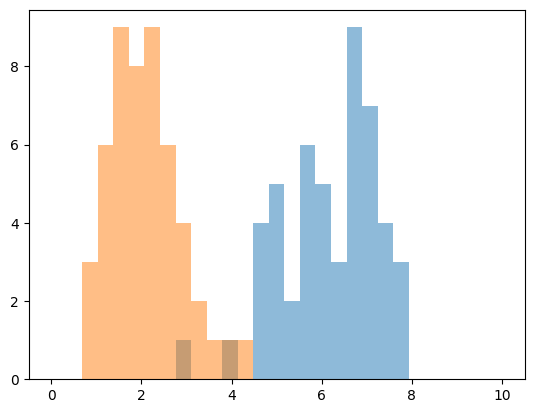

In [33]:
test_preds = svm.score_samples(x_test_scaled[:50])
anom_preds = svm.score_samples(x_anom_scaled[:50])

bins = np.linspace(0, 10, 30)
plt.hist(test_preds, bins=bins, alpha=0.5, label='test')
plt.hist(anom_preds, bins=bins, alpha=0.5, label='anom')

The book says 0.92. Done.

# QSVM model number 2

Now repeat the exercise but first do dimensionality reduction of the data using PCA. Reduce to the first 8 principal components. This allows the use of angular encoding on 8 qubits later.

In [207]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 8)

x_train_pca = pca.fit_transform(x_tr)
x_test_pca = pca.transform(x_test)

Now do angular embedding on 8 qubits, unlike the previous case.

In [208]:
nqubits = 8
dev = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    qml.AngleEmbedding(a, wires=range(nqubits))
    qml.adjoint(qml.AngleEmbedding(b, wires=range(nqubits)))
    return qml.probs(wires = range(nqubits))

The training takes 39 seconds.

In [209]:
svm = SVC(kernel = qkernel).fit(x_tr, y_tr)

print(accuracy_score(svm.predict(x_test), y_test))

0.9230769230769231


Perfect classification, as in the book.

# QSVM model number 3

Now use a different feature map. PennyLane comes with several prebuilt embedding templates:

https://docs.pennylane.ai/en/stable/introduction/templates.html

Here we illustrate a custom-made feature map.

In [205]:
from itertools import combinations

def ZZFeatureMap(nqubits, data):

    # Number of variables that we will load:
    # could be smaller than the number of qubits.
    nload = min(len(data), nqubits)

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) *
            (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

The training takes 75 seconds.

In [206]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    ZZFeatureMap(nqubits, a)
    qml.adjoint(ZZFeatureMap)(nqubits, b)
    return qml.probs(wires = range(nqubits))

svm = SVC(kernel=qkernel).fit(xs_tr, y_tr)
print(accuracy_score(svm.predict(xs_test), y_test))

0.9230769230769231


# Epilogue

Old school scatter plot of the best two original features.

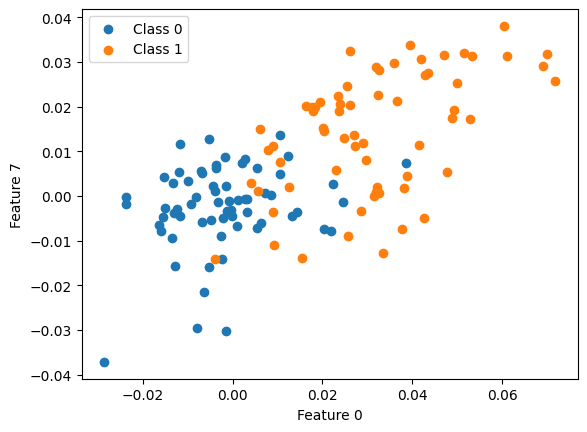

In [191]:
plt.scatter(x[:n_samples,0], x[:n_samples,7], label='Class 0')
plt.scatter(x[n_samples:,0], x[n_samples:,7], label='Class 1')
plt.legend()
plt.xlabel('Feature 0')
plt.ylabel('Feature 7')
plt.show()